# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders_prepared import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

# Warm start - берем только те user_id, которые есть в train
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [5]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

result_lvl_1 = result_lvl_1.loc[result_lvl_1['user_id'] != 296]
result_lvl_1 = result_lvl_1.loc[result_lvl_1['user_id'] != 1813]

result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [6]:
%%time
# топ-100 популярных товаров
top_100 = recommender.top_purchases.head(100).item_id.to_list()

result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=200))
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=200))

result_lvl_1['100own_100top'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=100)
                                                                        + top_100)

result_lvl_1.head(4)

CPU times: user 44min 38s, sys: 3min 29s, total: 48min 7s
Wall time: 45min 31s


,user_id,actual,als,own,similar_items,similar_users,100own_100top
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[885290, 1062572, 1097909, 5572898, 9527558, 7...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 914318, 826120, 5577022, 9803545, 983...","[1062572, 6552318, 6396492, 1091342, 1097909, ...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[916122, 5569230, 1092835, 1029743, 914577, 86...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[861279, 5569845, 917816, 985999, 880888, 8199...","[12352089, 875392, 9419422, 9802756, 1059080, ...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[821741, 891423, 1052294, 6391541, 1091383, 80...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[13213202, 846550, 1111786, 999714, 960075, 69...","[1003487, 8357825, 1052294, 1138596, 861990, 1...","[6391541, 1052294, 891423, 936470, 1137010, 11..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1051516, 1026118, 896613, 854852, 878996, 835...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 819308, 941361, 1074754, 110...","[7442505, 948640, 1015280, 1113675, 1075796, 8...","[13003092, 972416, 995598, 923600, 1138596, 10..."


In [7]:
for column in result_lvl_1.columns[2:]:
    recall = result_lvl_1.apply(lambda x: recall_at_k(x[column], x['actual'], k=200), axis=1).mean()
    print(f'{column} - recall_at_5: {recall}')

als - recall_at_5: 0.09707630995328953
own - recall_at_5: 0.13537278412833254
similar_items - recall_at_5: 0.0844664328364158
similar_users - recall_at_5: 0.014992673531042977
100own_100top - recall_at_5: 0.10751997969046655


Лучший Recall@k дают рекомендации собственного топа товаров, комбинация топ-100 своих и топ-100 всех товаров дают метрику чуть хуже, но лучше, чем все остальные модели

In [8]:
n_candidats = [20, 50, 100, 200, 300, 400, 500]
recalls = []
for n in n_candidats:
    result_lvl_1[f'als_{n}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=n))
    recall = result_lvl_1.apply(lambda x: recall_at_k(x[f'als_{n}'], x['actual'], k=n), axis=1).mean()
    recalls.append(recall)

recalls

[0.029258706382048506,
 0.04772660608140351,
 0.06867218895550044,
 0.09707630995328953,
 0.11739759884560426,
 0.13373071490741711,
 0.14785361255603693]

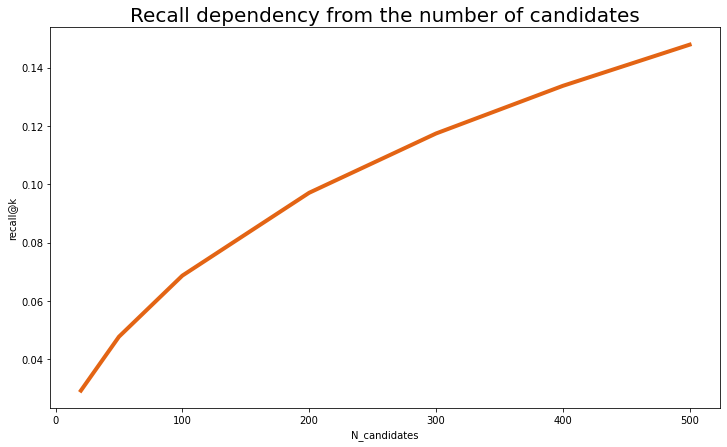

In [9]:
plt.figure(figsize = (12, 7))

plt.title('Recall dependency from the number of candidates', size=20)

plt.plot(n_candidats, recalls, label='mean', linestyle='solid', linewidth=4, color='#e36414')

plt.xlabel('N_candidates')
plt.ylabel('recall@k')
plt.show()

Для эксперимента использована модель ALS. На графике видно, что с ростом числа кандидатов recall возрастает, и среди выбранных значений N, 500 кандидатов дает самую высокую метрику. Но при мольшом числе кандидатов возможен большой дисбаланс классов в модели второго уровня.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [10]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))
users_lvl_2.head()

,user_id,candidates
0,2070,"[917033, 1056509, 5569230, 899624, 1029743, 80..."
1,2021,"[1119454, 950935, 871756, 10198378, 12731544, ..."
2,1753,"[1029743, 1106523, 822225, 5569230, 9526448, 1..."
3,2120,"[8090537, 5585510, 6534077, 1106523, 1013928, ..."
4,1346,"[5569309, 5574377, 1064002, 5569374, 916993, 9..."


In [11]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,917033,1
0,2070,1056509,1
0,2070,5569230,1
0,2070,899624,1


In [12]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [13]:
targets_lvl_2.head(2)

(   user_id  item_id  target
 0     2070   917033     0.0
 1     2070  1056509     0.0,
 0.04387902306561441)

In [14]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


## Добавим признаки

**Фичи user_id:**
- Средний чек
- Средняя сумма покупки 1 товара в каждой категории (55 руб для категории молоко, 230 руб для категории мясо, ...)
- Кол-во покупок в каждой категории
- Частотность покупок раз/месяц
- Долю покупок в выходные
- Долю покупок утром/днем/вечером
- ...

**Фичи item_id**:
- Кол-во покупок в неделю (молоко Домик в деревне --> 172 раза/неделю)
- Среднее кол-во покупок 1 товара в категории в неделю (категория молоко --> 556 раз/неделю)
- (Кол-во покупок в неделю конкретного товара) / (Среднее кол-во покупок 1 товара в категории в неделю)
- Цена (Можно посчитать из retil_train.csv) --> SUM(выручку за период, sales_value) / SUM(продажи за период, quantity) (молоко Домик в деревне --> 72 руб)
- Средняя цена товара в категории (категория молоко --> 56 руб)
- Цена / Средняя цена товара в категории

**Фичи пары user_id - item_id**
- (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id). // Пример {Средняя стоимость покупки юзером Вася в категории молоко = 46 руб} - {молоко Домик в деревне --> 72 руб} = 46-72 = -26
- (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю). {юзер Вася покупает молоко в среднем 3.3 раза/неделю} - {Среднестатистический юзер покупает молоко 1.5 неделю}
- (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [15]:
# количество товаров, купленных пользователем
UserOrdersCount = targets_lvl_2.user_id.value_counts().reset_index().rename(columns={'index':'user_id', 'user_id':'user_orders_count'})

targets_lvl_2 = targets_lvl_2.merge(UserOrdersCount, on='user_id', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_orders_count
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201


In [16]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [17]:
# количество товаров в категории
DepartmentCounts = item_features.department.value_counts().reset_index().rename(columns={'index':'department', 'department':'department_count'})

# item_features = item_features.merge(DepartmentCounts, on='department', how='left')
targets_lvl_2 = targets_lvl_2.merge(DepartmentCounts, on='department', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_orders_count,department_count
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,3118
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021


In [18]:
# количество товаров в подкатегории
CommodityCounts = item_features.commodity_desc.value_counts().reset_index().rename(columns={'index':'commodity_desc', 'commodity_desc':'commodity_count'})

# item_features = item_features.merge(CommodityCounts, on='commodity_desc', how='left')
targets_lvl_2 = targets_lvl_2.merge(CommodityCounts, on='commodity_desc', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_orders_count,department_count,commodity_count
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,1704
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,289
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,1704
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,3118,142
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,455


In [19]:
# средняя цена товара
data['price_per_item'] = data.sales_value / data.quantity
MeanPricePerItem = data.groupby('item_id')['price_per_item'].median().reset_index().rename(columns={'price_per_item':'mean_price_per_item'})

targets_lvl_2 = targets_lvl_2.merge(MeanPricePerItem, on='item_id', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_orders_count,department_count,commodity_count,mean_price_per_item
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,1704,3.00
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,289,1.99
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,1704,3.00
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,3118,142,3.99
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,455,2.49


In [20]:
# количество единиц каждого товара, купленного пользователем
n_items = data.groupby(['user_id', 'item_id'])['item_id'].count()
n_items = pd.DataFrame(n_items)
n_items.columns = ['n_items']
n_items.reset_index(inplace=True)
n_items.head()

targets_lvl_2 = targets_lvl_2.merge(n_items, on=['user_id', 'item_id'], how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_orders_count,department_count,commodity_count,mean_price_per_item,n_items
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,1704,3.00,4.0
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,289,1.99,1.0
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,1704,3.00,2.0
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,201,3118,142,3.99,4.0
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,201,39021,455,2.49,13.0


In [21]:
# число заказов пользователя
NOrders = data.groupby('user_id')['basket_id'].nunique().reset_index().rename(columns={'index':'user_id', 'basket_id':'n_orders'})
user_features = user_features.merge(NOrders, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(NOrders, on='user_id', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_orders_count,department_count,commodity_count,mean_price_per_item,n_items,n_orders
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,201,39021,1704,3.00,4.0,540
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,201,39021,289,1.99,1.0,540
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,201,39021,1704,3.00,2.0,540
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,...,Unknown,Unknown,1,None/Unknown,201,3118,142,3.99,4.0,540
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,Unknown,Unknown,1,None/Unknown,201,39021,455,2.49,13.0,540


In [22]:
# общая сумма покупок
MoneySpent = data.groupby('user_id')['sales_value'].sum().reset_index().rename(columns={'index':'user_id', 'sales_value':'money_spent'})
user_features = user_features.merge(MoneySpent, on='user_id', how='left')

# средняя сумма заказа
user_features['mean_order_value'] = user_features.money_spent / user_features.n_orders

targets_lvl_2 = targets_lvl_2.merge(MoneySpent, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features[['user_id', 'mean_order_value']], on='user_id', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,household_size_desc,kid_category_desc,user_orders_count,department_count,commodity_count,mean_price_per_item,n_items,n_orders,money_spent,mean_order_value
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,1,None/Unknown,201,39021,1704,3.00,4.0,540,6981.86,12.92937
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,...,1,None/Unknown,201,39021,289,1.99,1.0,540,6981.86,12.92937
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,1,None/Unknown,201,39021,1704,3.00,2.0,540,6981.86,12.92937
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,...,1,None/Unknown,201,3118,142,3.99,4.0,540,6981.86,12.92937
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,1,None/Unknown,201,39021,455,2.49,13.0,540,6981.86,12.92937


In [40]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [41]:
disbalance = targets_lvl_2.target.value_counts()[0] / targets_lvl_2.target.value_counts()[1]

In [43]:
cat_feats = X_train.columns[3:-9].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [84]:
%%time
#
lgb = LGBMClassifier(objective='binary',
                     max_depth=15,
                     n_estimators=1000,
                     learning_rate=0.1,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

proba = lgb.predict_proba(X_train)

targets_lvl_2['predict_proba'] = 1
targets_lvl_2['predict_proba'] = proba[:,1]
targets_lvl_2.head()

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 2min 38s, sys: 4.74 s, total: 2min 42s
Wall time: 53.5 s


,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,kid_category_desc,user_orders_count,department_count,commodity_count,mean_price_per_item,n_items,n_orders,money_spent,mean_order_value,predict_proba
0,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,None/Unknown,201,39021,1704,3.00,4.0,540,6981.86,12.92937,0.021585
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,45-54,...,None/Unknown,201,39021,289,1.99,1.0,540,6981.86,12.92937,0.018182
2,2070,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,None/Unknown,201,39021,1704,3.00,2.0,540,6981.86,12.92937,0.003301
3,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,...,None/Unknown,201,3118,142,3.99,4.0,540,6981.86,12.92937,0.479592
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,...,None/Unknown,201,39021,455,2.49,13.0,540,6981.86,12.92937,0.419953


In [85]:
recommendations = targets_lvl_2[['user_id', 'item_id', 'predict_proba']]
# recommendations = recommendations.sort_values(by=['user_id', 'predict_proba'], ascending=False)
# recommendations.groupby('user_id').head()

In [86]:
# Warm start - берем только те user_id, которые есть в train
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2['user_id'].isin(data_train_lvl_2['user_id'])]

result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2 = result_lvl_2.loc[result_lvl_2['user_id'] != 1984]
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [87]:
def model_2(user, N=5):
    return recommendations[recommendations['user_id'] == user].sort_values('predict_proba', ascending=False).head(N).item_id.tolist()

result_lvl_2['model_lvl_2'] = result_lvl_2['user_id'].apply(lambda x: model_2(x))
result_lvl_2['model_lvl_1'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=5))

result_lvl_2.head()

,user_id,actual,model_lvl_2,model_lvl_1
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[877391, 940947, 940947, 940947, 9655212]","[885290, 1062572, 1097909, 5572898, 9527558]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1082185, 1098844, 1098844, 845208]","[1051516, 1026118, 896613, 854852, 878996]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 9338009, 12524016, 5592610, 5590695]","[1041688, 6443332, 989275, 1044188, 10285022]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[9526274, 1029743, 1029743, 5591083, 1004906]","[916122, 1038985, 981660, 869388, 851528]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1114605, 1082185, 1029743, 1056005, 992826]","[1082212, 965530, 1139782, 1098910, 5566717]"


In [88]:
precision_at_5_model1 = result_lvl_2.apply(lambda x: precision_at_k(x['model_lvl_1'], x['actual'], k=5), axis=1).mean()
precision_at_5_model2 = result_lvl_2.apply(lambda x: precision_at_k(x['model_lvl_2'], x['actual'], k=5), axis=1).mean()

print(f'precision@5 Model level 1 (ALS): {precision_at_5_model1}\nprecision@5 Model level 2 (LightGBM): {precision_at_5_model2}')

precision@5 Model level 1 (ALS): 0.09806788511749348
precision@5 Model level 2 (LightGBM): 0.21368146214099218
